In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm

import scipy.fftpack as fft
from scipy import ndimage

import functools

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
CosmoParams_use,ClassyCosmo_use, CorrFclass_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)

AstroParams = zeus21.Astro_Parameters(CosmoParams_use)
AstroParams_stoch = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY=True)

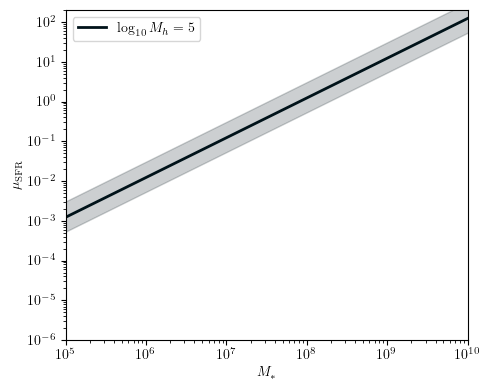

In [15]:
M = np.logspace(0,15,147)
Mh = HMFintclass_use.Mhtab
mu_SFR = M[:,np.newaxis] / Mh[np.newaxis,:] * (zeus21.sfrd.dMh_dt(AstroParams_stoch, CosmoParams_use, HMFintclass_use, Mh, 10.))[np.newaxis,:]

sigma_M = 0.3
sigma_SFR_lim = 0.19
sigma_SFR_idx = -0.12
sigma_SFR_use = np.zeros(len(M))
for m in range(len((M))):
    sigma_SFR_use[m] = max(sigma_SFR_lim, sigma_SFR_idx * (M[m] / 1e10 + sigma_SFR_lim))

# mu_SFR_21cmf = M[:,np.newaxis] * zeus21.cosmology.Hubinvyr(CosmoParams_use,10.) / 0.5

plt.figure(figsize=(5,4))
# plt.loglog(M,mu_SFR_21cmf[:,0],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[0]),1),color=colors[0])
plt.loglog(M,mu_SFR[:,0],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[0]),1),color=colors[0])
plt.fill_between(M,10**(np.log10(mu_SFR[:,0])-2*sigma_SFR_use),10**(np.log10(mu_SFR[:,0])+2*sigma_SFR_use),color=colors[0],alpha=0.2)

# plt.loglog(M,mu_SFR[:,20],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[20]),1),ls='--',color=colors[3])
# plt.loglog(M,mu_SFR[:,-1],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[-1]),1),ls=':',color=colors[5])
plt.legend()
plt.xlim(1e5,1e10)
plt.ylim(1e-6,2e2)
plt.xlabel(r'$M_*$')
plt.ylabel(r'$\mu_{\rm SFR}$')
plt.tight_layout()
plt.savefig('./mu_SFR.png')
plt.show()


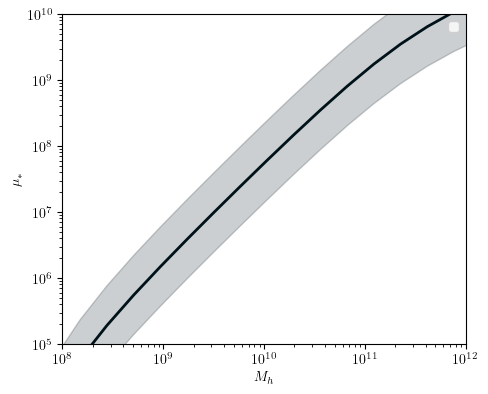

In [16]:
mu_M = zeus21.sfrd.fstarofz(AstroParams_stoch, CosmoParams_use, 10., Mh) * np.exp(-zeus21.sfrd.Matom(10.)/Mh) * Mh


plt.figure(figsize=(5,4))
plt.loglog(Mh,(mu_M),color=colors[0])
plt.fill_between(Mh,10**(np.log10(mu_M)-2*sigma_M),10**(np.log10(mu_M)+2*sigma_M),color=colors[0],alpha=0.2)
plt.legend()
plt.xlabel(r'$M_h$')
plt.ylabel(r'$\mu_{*}$')
plt.tight_layout()
plt.ylim(1e5,1e10)
plt.xlim(1e8,1e12)
plt.savefig('./mu_star.png')
plt.show()

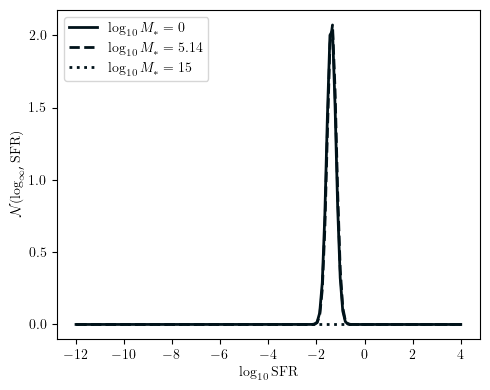

In [24]:
mu_SFR_0 = lambda m: m / Mh[0] * (zeus21.sfrd.dMh_dt(AstroParams_stoch, CosmoParams_use, HMFintclass_use, Mh[0], 10.))
# mu_SFR_20 = lambda m: m / Mh[20] * (zeus21.sfrd.dMh_dt(AstroParams_stoch, CosmoParams_use, HMFintclass_use, Mh[20], 10.))
# mu_SFR_h = lambda m: m / Mh[-1] * (zeus21.sfrd.dMh_dt(AstroParams_stoch, CosmoParams_use, HMFintclass_use, Mh[-1], 10.))

sigma_SFR = lambda m: max(sigma_SFR_lim, sigma_SFR_idx * (m / 1e10 + sigma_SFR_lim))

SFR_values = np.logspace(-12, 4, 151)

log_SFR_values = np.log10(SFR_values)

coeff_SFR = lambda m: 1. / (sigma_SFR(m) * np.sqrt(2 * np.pi))
p_logSFRM = lambda m: coeff_SFR(m) * np.exp(-(log_SFR_values - np.log10(mu_SFR_0(m) + np.log(10)*(sigma_SFR(m))**2/2.))**2 / (2 * sigma_SFR(m) ** 2))
# p_logSFRM_20 = lambda m: coeff_SFR(m) * np.exp(-(log_SFR_values - mu_SFR_20(m))**2 / (2 * sigma_SFR(m) ** 2))
# p_logSFRM_h = lambda m: coeff_SFR(m) * np.exp(-(log_SFR_values - mu_SFR_h(m))**2 / (2 * sigma_SFR(m) ** 2))

plt.figure(figsize=(5,4))

plt.plot(log_SFR_values,p_logSFRM(M[0]),label=r'$\log_{10}M_*=%g$'%round(np.log10(M[0]),2))#+r'$,\,\log_{10}M_h=%g$'%round(np.log10(Mh[0]),2))
plt.plot(log_SFR_values,p_logSFRM(M[50]),label=r'$\log_{10}M_*=%g$'%round(np.log10(M[50]),2)#+r'$,\,\log_{10}M_h=%g$'%round(np.log10(Mh[0]),2)
         ,ls='--',color=colors[0])
plt.plot(log_SFR_values,p_logSFRM(M[-1]),label=r'$\log_{10}M_*=%g$'%round(np.log10(M[-1]),2)#+r'$,\,\log_{10}M_h=%g$'%round(np.log10(Mh[0]),2)
         ,ls=':',color=colors[0])

plt.xlabel(r'$\rm \log_{10} SFR$')
plt.ylabel(r'$\mathcal{N(\log_{10}{\rm SFR})}$')
plt.legend()
plt.tight_layout()
plt.savefig('./p_SFR.png')


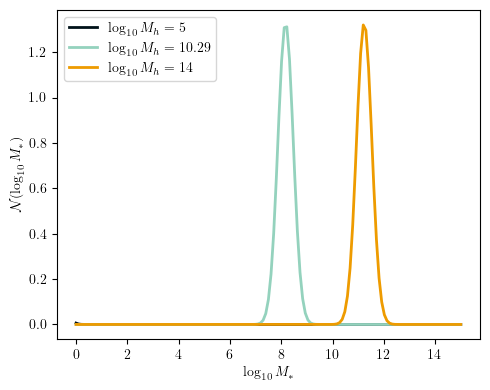

In [25]:
coeff_M = 1. / (sigma_M * np.sqrt(2 * np.pi))

mu_M = lambda mh : zeus21.sfrd.fstarofz(AstroParams_stoch, CosmoParams_use, 10., mh) * np.exp(-zeus21.sfrd.Matom(10.)/mh) * mh

log_mu_M_0 = np.log10(mu_M(Mh[0]) + np.log(10)*(sigma_M)**2/2)
log_mu_M_20 = np.log10(mu_M(Mh[20])+ np.log(10)*(sigma_M)**2/2)
log_mu_M_h = np.log10(mu_M(Mh[-1])+ np.log(10)*(sigma_M)**2/2)


p_logMMh_0 = coeff_M * np.exp(-(np.log10(M) - log_mu_M_0)**2 / (2 * sigma_M ** 2))
p_logMMh_20 = coeff_M * np.exp(-(np.log10(M) - log_mu_M_20)**2 / (2 * sigma_M ** 2))
p_logMMh_h = coeff_M * np.exp(-(np.log10(M) - log_mu_M_h)**2 / (2 * sigma_M ** 2))


plt.figure(figsize=(5,4))

log_M = np.log10(M)

plt.plot(log_M,p_logMMh_0,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[0]),2))
plt.plot(log_M,p_logMMh_20,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[20]),2),ls='-',color=colors[3])
plt.plot(log_M,p_logMMh_h,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[-1]),2) ,ls='-',color=colors[5])

plt.xlabel(r'$\log_{10} M_*$')
plt.ylabel(r'$\mathcal{N}(\log_{10}M_*)$')
plt.legend()
plt.tight_layout()
plt.savefig('./p_M.png')

In [26]:
SFR_marginalized_SFR = lambda m: zeus21.sfrd.simpson(p_logSFRM(m) / np.log(10)/SFR_values, SFR_values, axis=0)
for m in (M):
    if round(SFR_marginalized_SFR(m),0) != 1. and round(SFR_marginalized_SFR(m),0) != 0:
        print(m)

In [27]:
p_logMMh = lambda mh: coeff_M * np.exp(-(np.log10(M) - np.log10(mu_M(mh))))**2 / (2 * sigma_M ** 2)

SFR_marginalized_MSFR = lambda mh: zeus21.sfrd.simpson(SFR_marginalized_SFR * p_logMMh(m) / np.log(10) / M[:, np.newaxis, np.newaxis], M, axis=0)
for mh in (Mh):
    if round(SFR_marginalized_SFR(mh),0) != 1. and round(SFR_marginalized_SFR(mh),0) != 0:
        print(mh)

In [28]:
SFR_stoch = zeus21.sfrd.SFR_II(AstroParams_stoch,CosmoParams_use,HMFintclass_use,HMFintclass_use.Mhtab[np.newaxis,:],np.array((10.,11))[:,np.newaxis],0.)
SFR = zeus21.sfrd.SFR_II(AstroParams,CosmoParams_use,HMFintclass_use,HMFintclass_use.Mhtab[np.newaxis,:],np.array((10.,11))[:,np.newaxis],0.)

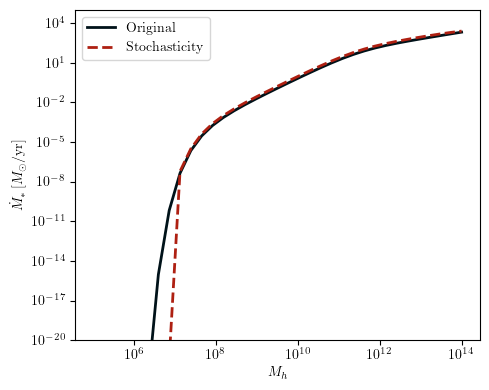

In [29]:
plt.figure(figsize=(5,4))

plt.loglog(HMFintclass_use.Mhtab,SFR[0],label=r'$\rm Original$')
plt.loglog(HMFintclass_use.Mhtab,SFR_stoch[0],label=r'$\rm Stochasticity$',c=colors[-2],ls='--')

#plt.loglog(HMFintclass_use.Mhtab,np.exp(HMFintclass_use.logHMFint((np.log(HMFintclass_use.Mhtab), 10.))),label=r'$dn/dM_h$',ls='-.')

plt.xlabel(r'$M_h$')
plt.ylabel(r'$\dot{M}_*\,[M_\odot/{\rm yr}]$')
plt.legend()
plt.ylim(1e-20,1e5)

plt.tight_layout()
plt.savefig('./SFR_stoch.png')


In [3]:
ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams, HMFintclass_use, zmin=ZMIN)
CoeffStructure_21_stoch = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_stoch, HMFintclass_use, zmin=ZMIN)

In [4]:
bar_SFRD = CoeffStructure_21.SFRDbar2D_II
bar_SFRD_stoch = CoeffStructure_21_stoch.SFRDbar2D_II

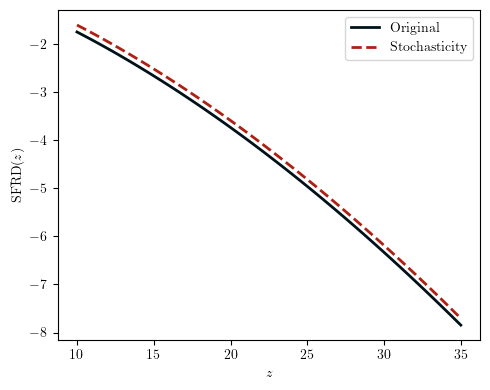

In [5]:
plt.figure(figsize=(5,4))

plt.plot(CoeffStructure_21.zintegral,np.log10(bar_SFRD[:,0]),label=r'$\rm Original$')
plt.plot(CoeffStructure_21.zintegral,np.log10(bar_SFRD_stoch[:,0]),label=r'$\rm Stochasticity$',c=colors[-2],ls='--')

plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{\rm SFRD}(z)$')
plt.legend()
plt.tight_layout()
plt.savefig('./SFRD_bar.png')


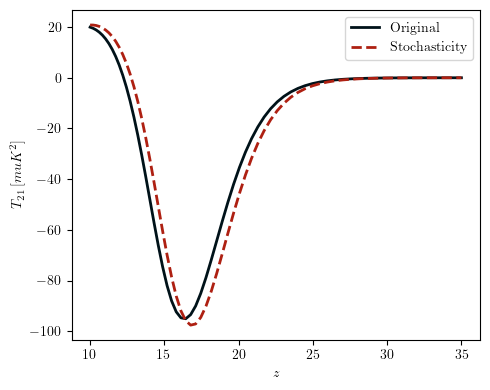

In [6]:
plt.figure(figsize=(5,4))
plt.plot(CoeffStructure_21.zintegral,CoeffStructure_21.T21avg,label=r'$\rm Original$')
plt.plot(CoeffStructure_21_stoch.zintegral,CoeffStructure_21_stoch.T21avg,label=r'$\rm Stochasticity$',c=colors[-2],ls='--')
plt.legend()

plt.xlabel(r'$z$')
plt.ylabel(r'$T_{21} \,[muK^2]$')

plt.tight_layout()
plt.savefig('./21cmstoch.png')


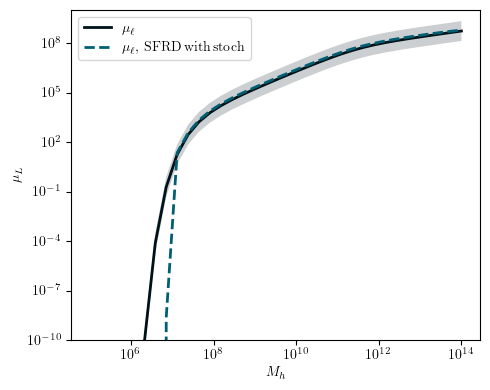

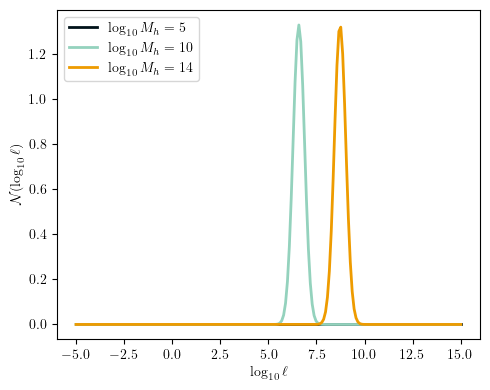

In [30]:
CII_alpha_SFR_0 = 1.4-0.07*10
CII_alpha_SFR_z = 0.
CII_beta_SFR_0 = 7.1-0.07*10
CII_beta_SFR_z = 0.
CII_sigma_LSFR = 0.3
z = 10.

Mh = HMFintclass_use.Mhtab

alpha_SFR = CII_alpha_SFR_0 + CII_alpha_SFR_z * z

beta_SFR = CII_beta_SFR_0 + CII_beta_SFR_z * z

try:
    alpha_SFR[alpha_SFR < 0.] = 0. 
except:
    if alpha_SFR < 0.:
        alpha_SFR = 0.

log10_L = alpha_SFR * np.log10(SFR[0]) + beta_SFR     
log10_L_stoch = alpha_SFR * np.log10(SFR_stoch[0]) + beta_SFR     

mu_L = 10.**log10_L
mu_L[abs(log10_L) == np.inf] = 0.
mu_L_stoch = 10.**log10_L_stoch
mu_L_stoch[abs(log10_L_stoch) == np.inf] = 0.

sigma_L = CII_sigma_LSFR 

Lval = np.logspace(-5,15,203)

coef =  1/(np.sqrt(2*np.pi)*sigma_L)

p_logL_0 = coef * np.exp(- (np.log10(Lval)-np.log10(mu_L[0]))**2/(2*sigma_L**2))
p_logL_20 = coef * np.exp(- (np.log10(Lval)-np.log10(mu_L[20]))**2/(2*sigma_L**2))
p_logL_h = coef * np.exp(- (np.log10(Lval)-np.log10(mu_L[-1]))**2/(2*sigma_L**2))

p_logL_0_stoch = coef * np.exp(- (np.log10(Lval)-np.log10(mu_L_stoch[0]))**2/(2*sigma_L**2))
p_logL_20_stoch = coef * np.exp(- (np.log10(Lval)-np.log10(mu_L_stoch[20]))**2/(2*sigma_L**2))
p_logL_h_stoch = coef * np.exp(- (np.log10(Lval)-np.log10(mu_L_stoch[-1]))**2/(2*sigma_L**2))


p_logL_0 = np.where(np.isnan(p_logL_0), 0, p_logL_0)
p_logL_20 = np.where(np.isnan(p_logL_20), 0, p_logL_20)
p_logL_h = np.where(np.isnan(p_logL_h), 0, p_logL_h)

p_logL_0_stoch = np.where(np.isnan(p_logL_0_stoch), 0, p_logL_0_stoch)
p_logL_20_stoch = np.where(np.isnan(p_logL_20_stoch), 0, p_logL_20_stoch)
p_logL_h_stoch = np.where(np.isnan(p_logL_h_stoch), 0, p_logL_h_stoch)

plt.figure(figsize=(5,4))
plt.loglog(Mh,mu_L,label=r'$\mu_\ell$')
plt.loglog(Mh,mu_L_stoch,label=r'$\mu_\ell,\,{\rm SFRD\,with\,stoch}$',ls='--')

plt.fill_between(Mh,10**(np.log10(mu_L)-2*sigma_L),10**(np.log10(mu_L)+2*sigma_L),alpha=0.2)

plt.xlabel(r'$M_h$')
plt.ylabel(r'$\mu_L$')
plt.legend()
plt.ylim(1e-10,1e10)
plt.tight_layout()
plt.savefig('./mu_L.png')

plt.figure(figsize=(5,4))

plt.plot(np.log10(Lval),p_logL_0,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[0]),0),color=colors[0])
plt.plot(np.log10(Lval),p_logL_20,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[20]),0),color=colors[3])
plt.plot(np.log10(Lval),p_logL_h,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[-1]),0),color=colors[5])

# plt.plot(np.log10(Lval),p_logL_0,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[0]),0),ls='--',color=colors[0])
# plt.plot(np.log10(Lval),p_logL_20,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[20]),0),ls='--',color=colors[3])
# plt.plot(np.log10(Lval),p_logL_h,label=r'$\log_{10}M_h=%g$'%round(np.log10(Mh[-1]),0),ls='--',color=colors[5])

plt.xlabel(r'$\log_{10} \ell$')
plt.ylabel(r'$\mathcal{N}(\log_{10}\ell)$')
plt.legend()
plt.tight_layout()
plt.savefig('./p_L.png')

In [18]:
LineParams = zeus21.Line_Parameters(zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 0.5,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.))

LineParams_stoch = zeus21.Line_Parameters(zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 0.5,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.3))

Your resolution introduces too large non linear corrections on small scales! 
We use instead MIN_R_NONLINEAR = 2 Mpc
Your resolution introduces too large non linear corrections on small scales! 
We use instead MIN_R_NONLINEAR = 2 Mpc


In [19]:
CorrFClass = zeus21.Correlations_LIM(LineParams, CosmoParams_use, ClassyCosmo_use)
CoeffStructure = zeus21.get_LIM_coefficients(CosmoParams_use,  AstroParams, HMFintclass_use, LineParams, zmin=10.)

CorrFClass_stoch = zeus21.Correlations_LIM(LineParams_stoch, CosmoParams_use, ClassyCosmo_use)
CoeffStructure_stoch = zeus21.get_LIM_coefficients(CosmoParams_use,  AstroParams, HMFintclass_use, LineParams_stoch, zmin=10.)

CoeffStructure_stoch_SFR = zeus21.get_LIM_coefficients(CosmoParams_use,  AstroParams_stoch, HMFintclass_use, LineParams_stoch, zmin=10.)

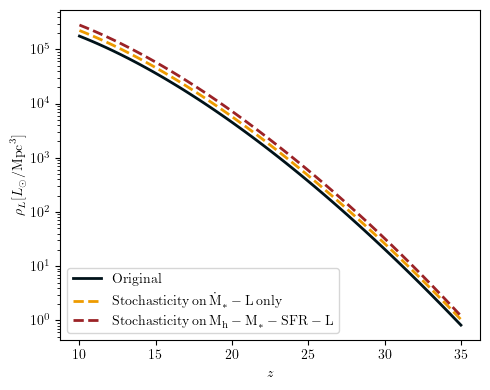

In [20]:
plt.figure(figsize=(5,4))
plt.semilogy(CoeffStructure.zGreaterMatrix,CoeffStructure.rhoLbar,'-',label=r'$\rm Original$')
plt.semilogy(CoeffStructure_stoch.zGreaterMatrix,CoeffStructure_stoch.rhoLbar,'--',label=r'$\rm Stochasticity\,on\,\dot{M}_*-L\,only$',color=colors[5])
plt.semilogy(CoeffStructure_stoch_SFR.zGreaterMatrix,CoeffStructure_stoch_SFR.rhoLbar,'--',label=r'$\rm Stochasticity\,on\,M_h-M_*-SFR-L$',color=colors[-1])
#plt.semilogy(CoeffStructure.zGreaterMatrix,CoeffStructure.rhoLbar, label=r'$\rm Lagache+18$')
plt.xlabel(r'$z$')
plt.ylabel(r'$\rho_L [L_\odot/{\rm Mpc}^3]$')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./rhobar_stoch.png')

In [21]:
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PSLIM = zeus21.Power_Spectra_LIM(CosmoParams_use, AstroParams, LineParams, CorrFClass, 'here we will put 21cm coeffs', CoeffStructure, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

PSLIM_stoch = zeus21.Power_Spectra_LIM(CosmoParams_use, AstroParams, LineParams_stoch, CorrFClass, 'here we will put 21cm coeffs', CoeffStructure_stoch, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

PSLIM_stoch_SFR = zeus21.Power_Spectra_LIM(CosmoParams_use, AstroParams_stoch, LineParams_stoch, CorrFClass, 'here we will put 21cm coeffs', CoeffStructure_stoch_SFR, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

Computed the LIM power spectrum.
Computed the LIM power spectrum.
Computed the LIM power spectrum.


(0.01, 1.0)

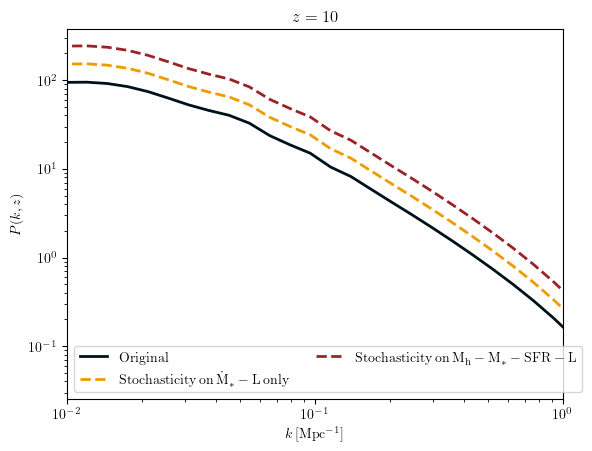

In [22]:
klist_LIM = PSLIM.klist_PS
zval = 10.

k3over2pi2 = klist_LIM**3/(2*np.pi**2)

zlist = CoeffStructure.zintegral
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zval)) #pick closest z

plt.loglog(klist_LIM,PSLIM.Deltasq_LIM[_iz]/k3over2pi2, color=colors[0],ls='-', label=r'$\rm Original$')
plt.loglog(klist_LIM,PSLIM_stoch.Deltasq_LIM[_iz]/k3over2pi2, color=colors[5], ls='--', label=r'$\rm Stochasticity\,on\,\dot{M}_*-L\,only$')
plt.loglog(klist_LIM,PSLIM_stoch_SFR.Deltasq_LIM[_iz]/k3over2pi2, color=colors[-1], ls='--', label=r'$\rm Stochasticity\,on\,M_h-M_*-SFR-L$')
plt.xlabel(r'$k\,{\rm [Mpc^{-1}]}$');
plt.ylabel(r'$P(k,z)$');
plt.legend(loc=3, ncol=2)
plt.title(r'$z = %g$'%10)
plt.xlim(1e-2,1e0)